# Finding Triangles in a Graph Using Grover's Algorithm

This Python code  implements Grover's algorithm using Qiskit to find triangles in a graph

## Why Use Quantum Computing for Triangle Finding?

1. Classical Complexity: Finding triangles in a graph is a common problem in computer science and network analysis. Classically, this is done by checking all possible triples of nodes, which, for large graphs, can be computationally expensive.

2. Quantum Advantage: Grover's algorithm provides a quadratic speedup for unstructured search problems. Utilizing quantum superposition and interference, it can search through N possibilities in approximately O(sqrt(N)) time time, compared to O(N) classically.



## **Overview** of the Code
The code consists of several components:



*  Graph Representation: Defines the graph's edges and nodes.

*  Combination Generation: Generates all possible combinations of nodes to search for triangles.

*  Oracle Construction: Creates a quantum oracle that marks the states representing triangles.

*  Diffuser (Amplification Operator): Constructs the diffuser circuit to amplify the probability of measuring the solution states.

*  Grover's Algorithm Circuit: Builds the overall quantum circuit implementing Grover's algorithm.

*  Simulation and Measurement: Runs the circuit on a quantum simulator and interprets the results.



In [49]:
# Define a more complex graph as a list of edges and nodes
edges = [
    (0, 1),
    (1, 2),(2,3),
   (2, 0),  (1, 3)
]
n_nodes = 6  # Number of nodes in the graph


In [17]:
pip install -U qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 81.6 MB/s eta 0:00:00


## Optimization: Using Ancilla Qubits for Efficient mcx Gates
using ancilla qubits to optimize multi-controlled X gates.

Why This Optimization? Multi-controlled Gates: The mcx gate without ancilla qubits (mcx with mode 'noancilla') has a higher gate count and depth. Ancilla-Assisted mcx Gates: By allowing the use of ancilla qubits, we can use more efficient implementations of mcx, reducing the circuit complexity. How to Implement It Add Ancilla Qubits:

Introduce additional qubits to serve as ancilla (helper) qubits. Modify Oracle and Diffuser to Use Ancillae:

Use the mcx gate with the 'recursion' or 'v-chain' mode, which requires ancilla qubits but is more efficient.

In [50]:
import numpy as np
from math import pi, sqrt, floor, ceil, log2
from itertools import combinations
from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import Aer


In [51]:
# Function to generate all combinations of 3 nodes
def generate_combinations(n, r=3):
    """Generates all combinations of r nodes from n nodes."""
    return list(combinations(range(n), r))

# Function to check if a combination of nodes forms a triangle
def is_triangle(nodes_combination, edges_set):
    """Checks if the given combination of nodes forms a triangle."""
    u, v, w = nodes_combination
    return ((u, v) in edges_set or (v, u) in edges_set) and \
           ((v, w) in edges_set or (w, v) in edges_set) and \
           ((u, w) in edges_set or (w, u) in edges_set)

# Prepare the search space and solutions
edges_set = set(edges)
combinations_list = generate_combinations(n_nodes)
n_combinations = len(combinations_list)
solutions = [i for i, comb in enumerate(combinations_list) if is_triangle(comb, edges_set)]
n_solutions = len(solutions)

print(f"Total combinations: {n_combinations}")
print(f"Number of triangles (solutions): {n_solutions}")


Total combinations: 20
Number of triangles (solutions): 2


In [52]:
# Calculate the number of qubits needed
n_index_qubits = ceil(log2(n_combinations))  # Number of qubits to index the combinations
n_ancillae = max(0, n_index_qubits - 2)  # Number of ancilla qubits needed for mcx gates
n_index_qubits

5

In [53]:
# ORACLE
def create_oracle(n_index_qubits, solutions, n_ancillae):
    """Creates an oracle that flips the phase of the states corresponding to solutions using ancilla qubits."""
    oracle = QuantumCircuit(n_index_qubits + n_ancillae, name='Oracle')
    for solution in solutions:
        # Create a circuit to flip the phase of the solution state
        b_solution = format(solution, f'0{n_index_qubits}b')
        oracle_temp = QuantumCircuit(n_index_qubits + n_ancillae)
        # Apply X gates to qubits where the solution bit is 0
        for i, bit in enumerate(b_solution):
            if bit == '0':
                oracle_temp.x(i)
        # Apply multi-controlled Z gate using ancilla qubits
        control_qubits = list(range(n_index_qubits - 1))
        target_qubit = n_index_qubits - 1
        ancilla_qubits = list(range(n_index_qubits, n_index_qubits + n_ancillae))
        oracle_temp.h(target_qubit)
        oracle_temp.mcx(
            control_qubits,
            target_qubit,
            ancilla_qubits,
            mode='basic'  # Use 'basic' mode for compatibility
        )
        oracle_temp.h(target_qubit)
        # Apply X gates again to revert
        for i, bit in enumerate(b_solution):
            if bit == '0':
                oracle_temp.x(i)
        # Combine the oracle circuits
        oracle = oracle.compose(oracle_temp, qubits=range(n_index_qubits + n_ancillae))
    return oracle.to_gate()


In [54]:
# DIFFUSER
def create_diffuser(n_index_qubits, n_ancillae):
    """Creates the diffuser (inversion about the mean) circuit using ancilla qubits."""
    diffuser = QuantumCircuit(n_index_qubits + n_ancillae, name='Diffuser')
    # Apply Hadamard gates
    diffuser.h(range(n_index_qubits))
    # Apply X gates
    diffuser.x(range(n_index_qubits))
    # Apply multi-controlled Z gate using ancilla qubits
    control_qubits = list(range(n_index_qubits - 1))
    target_qubit = n_index_qubits - 1
    ancilla_qubits = list(range(n_index_qubits, n_index_qubits + n_ancillae))
    diffuser.h(target_qubit)
    diffuser.mcx(
        control_qubits,
        target_qubit,
        ancilla_qubits,
        mode='basic'  # Use 'basic' mode for compatibility
    )
    diffuser.h(target_qubit)
    # Apply X gates
    diffuser.x(range(n_index_qubits))
    # Apply Hadamard gates
    diffuser.h(range(n_index_qubits))
    return diffuser.to_gate()


In [55]:
def grover_search(n_index_qubits, oracle_gate, diffuser_gate, n_iterations, n_ancillae):
    """Builds the Grover's algorithm circuit using ancilla qubits."""
    # Create quantum and classical registers
    qr = QuantumRegister(n_index_qubits + n_ancillae, name='q')
    cr = ClassicalRegister(n_index_qubits, name='c')
    qc = QuantumCircuit(qr, cr)
    # Initialize qubits in superposition
    qc.h(range(n_index_qubits))
    # Apply Grover iterations
    for _ in range(n_iterations):
        qc.append(oracle_gate, qr)
        qc.append(diffuser_gate, qr)
    # Measure the qubits
    qc.measure(range(n_index_qubits), cr)
    return qc


In [56]:
# Calculate the optimal number of iterations
n_iterations = floor((pi / 4) * sqrt(n_combinations / n_solutions))
if n_iterations == 0:
    n_iterations = 1  # Ensure at least one iteration

print(f"Number of Grover iterations: {n_iterations}")


Number of Grover iterations: 2


In [57]:
n_solutions

2

In [58]:
# Create the oracle and diffuser circuits with ancilla qubits
oracle_gate = create_oracle(n_index_qubits, solutions, n_ancillae)
diffuser_gate = create_diffuser(n_index_qubits, n_ancillae)


In [59]:
# Build the Grover's algorithm circuit with ancilla qubits
qc = grover_search(n_index_qubits, oracle_gate, diffuser_gate, n_iterations, n_ancillae)


In [60]:
qc.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─┐            
q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├┤M├────────────
     ├───┤│         ││           ││         ││           │└╥┘┌─┐         
q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├─╫─┤M├─────────
     ├───┤│         ││           ││         ││           │ ║ └╥┘┌─┐      
q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├─╫──╫─┤M├──────
     ├───┤│         ││           ││         ││           │ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├─╫──╫──╫─┤M├───
     ├───┤│  Oracle ││  Diffuser ││  Oracle ││  Diffuser │ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├┤4        ├┤4          ├┤4        ├┤4          ├─╫──╫──╫──╫─┤M├
     └───┘│         ││           ││         ││           │ ║  ║  ║  ║ └╥┘
q_5: ─────┤5        ├┤5          ├┤5        ├┤5          ├─╫──╫──╫──╫──╫─
          │         ││           ││         ││           │ ║  ║  ║  ║  ║ 
q_6: ─────┤6        ├┤6          ├┤6        ├┤6          ├─╫──╫──╫──╫──╫─
          │         ││           ││         ││           │ ║  ║  ║  ║  ║ 
q_7: ─────┤7        ├┤7          ├┤7        ├┤7          ├─╫──╫──╫──╫──╫─
          └─────────┘└───────────┘└─────────┘└───────────┘ ║  ║  ║  ║  ║ 
c: 5/══════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                           0  1  2  3  4

In [61]:
# Analyze the circuit
print("\n--- Circuit Statistics ---")
print(f"Circuit Depth: {qc.depth()}")
print(f"Circuit Size: {qc.size()}")
print(f"Circuit Width (Total Qubits): {qc.width()}")
print(f"Number of Qubits: {qc.num_qubits}")
print("Gate Counts:")
gate_counts = qc.count_ops()
for gate, count in gate_counts.items():
    print(f"  {gate}: {count}")



--- Circuit Statistics ---
Circuit Depth: 6
Circuit Size: 14
Circuit Width (Total Qubits): 13
Number of Qubits: 8
Gate Counts:
  h: 5
  measure: 5
  Oracle: 2
  Diffuser: 2


In [62]:
# Simulate the circuit
backend = Aer.get_backend('qasm_simulator')
shots = 2048
# Transpile the circuit for the simulator
qc_compiled = transpile(qc, backend)
# Execute the circuit
job = backend.run(qc_compiled, shots=shots)
result = job.result()
counts = result.get_counts()


In [63]:
# Print the measurement results
print("\nMeasurement results:")
for state, count in counts.items():
    print(f"{state}: {count} times")

# Map the measurement results to node combinations
print("\nTriangles found:")
for state, count in counts.items():
    index = int(state, 2)
    if index < n_combinations:
        comb = combinations_list[index]
        if is_triangle(comb, edges_set):
            print(f"Nodes {comb} form a triangle, measured {count} times.")



Measurement results:
10000: 2 times
11011: 3 times
11111: 6 times
11000: 4 times
01000: 3 times
01100: 6 times
01001: 11 times
00101: 14 times
10001: 8 times
11010: 7 times
11100: 7 times
10101: 8 times
10010: 8 times
01011: 6 times
00011: 8 times
00111: 6 times
10111: 8 times
10100: 5 times
01010: 897 times
01101: 8 times
11101: 13 times
10011: 6 times
00000: 949 times
11001: 8 times
10110: 6 times
01111: 6 times
00001: 8 times
00110: 5 times
00010: 2 times
01110: 8 times
00100: 8 times
11110: 4 times

Triangles found:
Nodes (1, 2, 3) form a triangle, measured 897 times.
Nodes (0, 1, 2) form a triangle, measured 949 times.


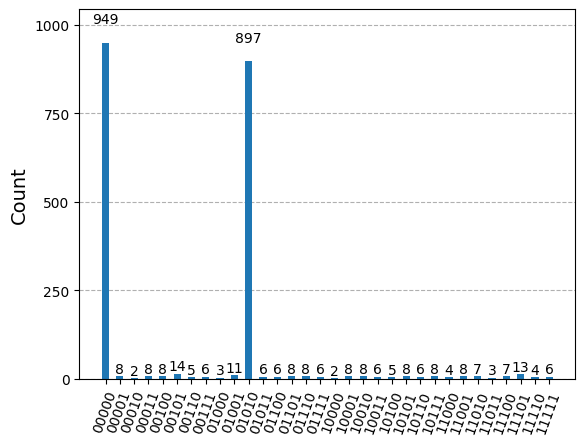

In [64]:
# Plot the histogram of results
plot_histogram(counts)


 Observations and Conclusions
Impact of Optimization: By comparing the circuit statistics before and after optimization, you should see a significant difference in depth and size.
Measurement Results: The measurement results should be similar in terms of identifying the triangles, but the optimized circuit is more efficient.
Optimization Logic Validity: The differences in circuit statistics confirm that the optimization logic is valid and has a tangible impact.